In [1]:
#import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import requests
import re
from config import key

In [2]:
#user input Minnesota city name, string
city = "Minneapolis"
#user input 3 digit fish_id, string
species = "NOP"
#user input search distance in miles from city, float
travel = 20
#user input number of results desired
requested_results = 8
#user input YYYY-MM-DD format, datetime64
start_date = np.datetime64("2000-01-31")
#user input gear from gear list, string, optional
gear = "Standard gill nets"

In [3]:
#read .csv files
lakes_data = pd.read_csv("Resources/lake_info/lake_information_clean.csv", converters={"lake_ID": str})
fish_id = pd.read_csv("Resources/fish_id_info/fish_id_list.csv")

In [4]:
# call API to return city geo coordinates
params = {
    "city": city,
    "state": "MN",
    "country": "United States of America",
    "apiKey": key
}
base_url = "https://api.geoapify.com/v1/geocode/search"
response = requests.get(base_url, params=params).json()
city_lon = response["features"][0]["geometry"]["coordinates"][0]
city_lat = response["features"][0]["geometry"]["coordinates"][1]

In [5]:
#data cleaning methods
#sort and format year survey data then convert to datetime
def survey_date_cleaner(dfseries):
    dfseries = dfseries.copy()
    for _ in range(len(dfseries)):
        dfseries[_] = dfseries[_].replace("/","-")
        if matches := re.search(r"^(\d?\d{1})-(\d?\d{1})-(\d{4})$", dfseries[_], re.IGNORECASE):
            dfseries[_] = f"{matches.group(3)}-{matches.group(2)}-{matches.group(1)}"
        try:
            dfseries[_] = pd.to_datetime(dfseries[_],format="%Y-%m-%d")
        except ValueError:
            if matches := re.search(r"^(\d{4})-(\d?\d{1})-(\d?\d{1})$", dfseries[_], re.IGNORECASE):
                dfseries[_] = f"{matches.group(1)}-{matches.group(3)}-{matches.group(2)}"
            dfseries[_] = pd.to_datetime(dfseries[_],format="%Y-%m-%d")
    dfseries = pd.to_datetime(dfseries,format="%Y-%m-%d")
    return dfseries

#input CPUE column data series
#drop strings from cpue data series and convert to int(found some "? marks")
def cpue_cleaner(dfseries):
    i=0
    for _ in dfseries:
        try:
            np.float64(_)
            i = i + 1
        except ValueError:
            print(i, _,"valueerror")
            dfseries = dfseries.drop([i])
            i = i + 1
    dfseries = pd.to_numeric(dfseries)
    return dfseries

#input quartile data series
#split lower quartile and convert to float
def lower_quartile_cleaner(dseries):
    quartile_list = []
    for quartile in dseries:
        try:
            if len(quartile.split("-")) == 2:
                try:
                    quartile_list.append(float(quartile.split("-")[0]))
                except ValueError:
                    quartile_list.append(float("nan"))
                    pass
            else:
                quartile_list.append(float("nan"))
        except AttributeError:
            quartile_list.append(quartile)
            pass
    return quartile_list

#input quartile data series
#split upper quartile and convert to float
def upper_quartile_cleaner(dseries):
    quartile_list = []
    for quartile in dseries:
        try:
            if len(quartile.split("-")) == 2:
                try:
                    quartile_list.append(float(quartile.split("-")[1]))
                except ValueError:
                    quartile_list.append(float("nan"))
                    pass
            else:
                quartile_list.append(float("nan"))
        except AttributeError:
            quartile_list.append(quartile)
            pass
    return quartile_list

#input fish_count column data series
#returns fish_count column in dataframe as a list of individual integer measurements e.g. [0,0,1,1,1,2,3,3,4]
def fish_length_cleaner(dfseries):
    fish_lengths = []
    #scrub each row string and convert to list of lengths sampled
    for row in dfseries:
        sample_lengths = []
        for n in range(len(row)):
            for i in range(row[n][1]):
                sample_lengths.append(row[n][0])
        fish_lengths.append(sample_lengths)
    return fish_lengths

In [6]:
#data requesting and preparation methods

#convert coordinate lat or lon from degrees to radians; coordinate = -94.728528
def get_radians(coordinate):
    radian = coordinate*np.pi/180
    return radian

#calculate distance between 2 geographic degree points; lon1 = -94.728528 , lat1 = 44.308025
def get_distance(lat1, lon1, lat2, lon2):
    distance = np.arccos(np.sin(get_radians(lat1))*np.sin(get_radians(lat2)) + \
                         np.cos(get_radians(lat1))*np.cos(get_radians(lat2)) * \
                         np.cos(get_radians(lon2)-get_radians(lon1)))*3958.8
    return distance

#JSON response for MN lake id number.
def get_catch_info(lake_id):
    response = requests.get("https://maps2.dnr.state.mn.us/cgi-bin/lakefinder/detail.cgi?type=lake_survey&id="+lake_id)
    return response.json()

#fish catch summary returns a list of dictionaries cpue by species by survey ID using API response
def get_fish_catch_summary_data(catch_info):
    fish_catch_list = []
    for i in range(len(catch_info["result"]["surveys"])): 
        survey_date = catch_info["result"]["surveys"][i]["surveyDate"]
        survey_id = catch_info["result"]["surveys"][i]["surveyID"]
        for j in range(len(catch_info["result"]["surveys"][i]["fishCatchSummaries"])):
            fish_catch_summary = catch_info["result"]["surveys"][i]["fishCatchSummaries"][j]
            fish_catch_summary["lake_ID"] = catch_info["result"]["DOWNumber"]
            fish_catch_summary["survey_date"] = survey_date
            fish_catch_summary["survey_ID"] = survey_id
            fish_catch_list.append(fish_catch_summary)
    return fish_catch_list

#fish length summary returns a list of dictionaries lengths and counts by species by survey ID using API response
def get_fish_length_summary_data(lake_info):
    fish_length_list = []
    for i in range(len(lake_info["result"]["surveys"])): 
        survey_date = lake_info["result"]["surveys"][i]["surveyDate"]
        survey_id = lake_info["result"]["surveys"][i]["surveyID"]
        for j in lake_info["result"]["surveys"][i]["lengths"].keys():
            fish_length_summary = {}
            fish_length_summary["lake_ID"] = lake_info["result"]["DOWNumber"]
            fish_length_summary["species"] = j
            fish_length_summary["fish_count"] = lake_info["result"]["surveys"][i]["lengths"][j]["fishCount"]
            fish_length_summary["maximum_length"] = lake_info["result"]["surveys"][i]["lengths"][j]["maximum_length"]
            fish_length_summary["minimum_length"] = lake_info["result"]["surveys"][i]["lengths"][j]["minimum_length"]
            fish_length_summary["survey_date"] = survey_date
            fish_length_summary["survey_ID"] = survey_id
            fish_length_list.append(fish_length_summary)
    return fish_length_list

#create a list of dictionaries to convert into a pandas dataframe
def create_cpue_dataframe(fish_data):
    catch_list = []
    for _ in range(len(fish_data)):
        catch = get_fish_catch_summary_data(fish_data[_])
        for _ in range(len(catch)):
            sample = catch[_]
            catch_list.append(sample)
    return pd.DataFrame(catch_list)

#alter API data return so it can be used in pandas dataframe for lengths
def create_length_dataframe(fish_data):
    length_list = []
    for _ in range(len(fish_data)):
        catch = get_fish_length_summary_data(fish_data[_])
        for _ in range(len(catch)):
            sample = catch[_]
            length_list.append(sample)
    return pd.DataFrame(length_list)

In [7]:
#plotting and preparation methods

#input fish_catch_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64, gear as str
#returns list of cpue column in dataframe for boxplot
def get_cpue_box(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    cpue_boxplot_list = []
    for lakeid in lakes:
        species_cpue = df.loc[(df["species"] == species) & \
                            (df["gear"] == gear) & \
                            (df["survey_date"] >= start_date) & \
                            (df["lake_ID"] == lakeid), "CPUE"]
        if species_cpue.empty == False:
            cpue_boxplot_list.append(species_cpue)
    return cpue_boxplot_list

#uses a list format to plot cpue boxplots
def plot_cpue_box(fishlist, lakes):
    plt.boxplot(fishlist)
    labels = lake_labels
    ticks = range(1, len(lakes)+1)
    plt.xticks(ticks=ticks, labels=labels, rotation=45, ha="right")
    plt.title(species_name)
    plt.show()
    
#input length_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#returns dictionary of fish_count column in dataframe for histogram, format {lake ID:[0,0,1,2,2,2,2,3,3]}
def get_length_hist(df, lakes, species, start_date=np.datetime64("1900-01-31")):
    fishdict = {}
    for lakeid in lakes:
        #sort by lake and species
        species_length = df.loc[(df["species"] == species) & \
                                    (df["survey_date"] >= start_date) & \
                                    (df["lake_ID"] == lakeid), "fish_count"]        
        fish_list = []
        for _ in species_length.values:
            fish_list = _ + fish_list
        fishdict[lakeid] = fish_list
    return fishdict

#Uses a dictionary format {lake ID:[0,0,1,2,2,2,2,3,3]} to plot fish length histograms
def plot_length_hist(fishdict):
    i = -1
    for lakeid in fishdict.keys():
        i += 1
        if bool(fishdict[lakeid]) == False:
            print(f"{lakeid} did not return results for the timeframe or species specified.")
        else:
            plt.hist(fishdict[lakeid])
            plt.xlabel("Size in Inches")
            plt.ylabel("Number sampled")
            plt.title(f"{lake_labels[i]} lengths for {species_name}")
            plt.show()

#input string data series with rows of "[1,1,2,2,2,3,4,7,7,7]"
#returns fish_count series column as a list of float averages e.g. [5.1, 4.6, 8.8]
def fish_length_averager(dfseries):
    fish_length_averages = []
    for row in dfseries:
        fish_length_averages.append(np.mean(row))
    return fish_length_averages

#input cpue_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return cpue data for scatterplot using fish data dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_cpue_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_cpue_list = []
    for lakeid in lakes:
        species_cpue = df.loc[(df["species"] == species) & \
                            (df["survey_date"] >= start_date) & \
                            (df["gear"] == gear) & \
                            (df["lake_ID"] == lakeid), "CPUE"]
        lake_scatter_cpue_list.append(species_cpue)
    return lake_scatter_cpue_list

#input length_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return avg species length data for scatterplot using fish length dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_avglen_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31")):
    lake_scatter_length_list = []
    for lakeid in lakes:
        species_length = df.loc[(df["species"] == species) & \
                                    (df["survey_date"] >= start_date) & \
                                    (df["lake_ID"] == lakeid), "average_length"]
        lake_scatter_length_list.append(species_length)
    return lake_scatter_length_list

#input df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return survey date data for scatterplot using dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_survey_date_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_survey_date_list = []
    for lakeid in lakes:
        try:
            species_survey_date = df.loc[(df["species"] == species) & \
                                (df["gear"] == gear) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "survey_date"]
        except KeyError:
            species_survey_date = df.loc[(df["species"] == species) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "survey_date"]            
        lake_scatter_survey_date_list.append(species_survey_date)
    return lake_scatter_survey_date_list

#input df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return numeric survey date data for regression line using dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_numeric_survey_date_regress(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_numeric_survey_date_list = []
    for lakeid in lakes:
        try:
            lake_scatter_numeric_survey_date = df.loc[(df["species"] == species) & \
                                (df["gear"] == gear) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "numeric_survey_date"]
        except KeyError:
            lake_scatter_numeric_survey_date = df.loc[(df["species"] == species) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "numeric_survey_date"]            
        lake_scatter_numeric_survey_date_list.append(lake_scatter_numeric_survey_date)
    return lake_scatter_numeric_survey_date_list

#input fish= length or cpue series int, sdate= survey date series datetime64, lakes= [list of lake id], ytext= ylabel value
#scatter plot average lengths per lake
def plot_scatter(fish, sdate, lakes, ytext=""):
    for _ in range(len(lakes)):
        plt.scatter(sdate[_],fish[_], label=lake_labels[_])
    plt.title(f"{ytext} measurements for {species_name}")
    plt.ylabel(f"{species_name} {ytext}")
    plt.xlabel("Date")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc="best", labels=lake_labels)
    plt.show()
    
#plot regression lines with scatter plots for each lake
def plot_regression_scatter(fish, sdate, ndate, lakes, ytext=""):
    print("Notes:")
    for lake in range(len(lakes)):
        if len(ndate[lake]) == 0:
            print(f"Survey Data Empty for {lake_labels[lake]}")
        elif len(ndate[lake]) == 1:
            print(f"Only 1 data point exists for {lake_labels[lake]}")
        else:
            regression_values = linregress(ndate[lake],fish[lake])
            fig, ax1 = plt.subplots(1,1)
            fig.suptitle(f"{ytext} trend for {lake_labels[lake]}")
            ax1.scatter(sdate[lake],fish[lake], label=lake_labels[lake])
            ax1.set_ylabel(f"{species_name} {ytext}")
            ax1.set_xlabel(f"R2 value = {regression_values.rvalue}")
            plt.xticks(rotation=45)
            ax2 = ax1.twiny()
            ax2.plot(ndate[lake],(regression_values.slope*ndate[lake] + regression_values.intercept))
    plt.show()

In [8]:
#search csv lake data for lakes within travel distance
closeby = lakes_data.loc[(get_distance(city_lat, city_lon, lakes_data["Latitude"], lakes_data["Longitude"]) < travel)]
#turn csv lake data into a list of lake ids
lakes = list(closeby["lake_ID"])
results_length = len(lakes)
print(f"Search returned {results_length} lakes")

Search returned 319 lakes


In [9]:
#retrieve catch survey data from API for all lakes within radius that have survey
fish_data = [get_catch_info(x) for x in lakes if get_catch_info(x)["status"] == "SUCCESS"]

In [14]:
#create a dataframe for the cpue
fish_catch_df = create_cpue_dataframe(fish_data)
data_entries = len(fish_catch_df.index)
print(f"Search returned {data_entries} data points")

Search returned 17450 data points


In [15]:
#clean incomming API data
fish_catch_df["CPUE"] = cpue_cleaner(fish_catch_df["CPUE"])
fish_catch_df["survey_date"] = survey_date_cleaner(fish_catch_df["survey_date"])
fish_catch_df["count_lower_quartile"] = lower_quartile_cleaner(fish_catch_df["quartileCount"])
fish_catch_df["count_upper_quartile"] = upper_quartile_cleaner(fish_catch_df["quartileCount"])
fish_catch_df["weight_lower_quartile"] = lower_quartile_cleaner(fish_catch_df["quartileWeight"])
fish_catch_df["weight_upper_quartile"] = upper_quartile_cleaner(fish_catch_df["quartileWeight"])
fish_catch_df["gearCount"] = fish_catch_df["gearCount"].astype("int")
fish_catch_df = fish_catch_df.drop(columns=["quartileCount", "quartileWeight"])
fish_catch_df = fish_catch_df.sort_values("survey_date")

743 ∞ valueerror
745 ∞ valueerror
753 ∞ valueerror
792 ∞ valueerror
806 ∞ valueerror
811 ∞ valueerror
814 ∞ valueerror
817 ∞ valueerror
819 ∞ valueerror
930 ∞ valueerror
3973 ∞ valueerror
4773 ∞ valueerror
4774 ∞ valueerror
6149 ∞ valueerror
6988 ∞ valueerror
10672 ∞ valueerror
10687 ∞ valueerror
11472 ∞ valueerror
11474 ∞ valueerror
11483 ∞ valueerror
12238 ∞ valueerror
12242 ∞ valueerror
12253 ∞ valueerror
12343 ∞ valueerror
12345 ∞ valueerror
12357 ∞ valueerror
12853 ∞ valueerror
12854 ∞ valueerror
12855 ∞ valueerror
12858 ∞ valueerror
12859 ∞ valueerror
12861 ∞ valueerror
12862 ∞ valueerror
12867 ∞ valueerror
12870 ∞ valueerror
13478 ∞ valueerror
13479 ∞ valueerror
13488 ∞ valueerror
13777 ∞ valueerror
13779 ∞ valueerror
13796 ∞ valueerror
14308 ∞ valueerror
14752 ∞ valueerror
16444 ∞ valueerror
16708 ∞ valueerror


In [16]:
#add numeric survey date column as an integer to fish CPUE
fish_catch_df["survey_date"] = pd.to_datetime(fish_catch_df["survey_date"],format="%Y-%m-%d")
fish_catch_df["numeric_survey_date"] = pd.to_numeric(fish_catch_df["survey_date"])
fish_catch_df = fish_catch_df.sort_values("survey_date")
fish_catch_df = fish_catch_df.reset_index(drop=True)

In [17]:
#get the highest median cpue values, only return those with results above the median of all API responses
median_catch = fish_catch_df.loc[(fish_catch_df["species"] == species) & (fish_catch_df["survey_date"] >= start_date)]
median_catch = median_catch["lake_ID"].value_counts().loc[median_catch["lake_ID"].value_counts() >= median_catch["lake_ID"].value_counts().median()]
median_catch = list(median_catch.index)

#sort median cpue descending order
median_cpue = fish_catch_df.loc[(fish_catch_df["species"] == species) & \
                                (fish_catch_df["survey_date"] >= start_date) & \
                                (fish_catch_df["lake_ID"].isin(median_catch)) & \
                                (fish_catch_df["gear"] == gear)]
median_cpue = median_cpue.groupby("lake_ID").median() ["CPUE"]
median_cpue = median_cpue.sort_values(ascending=False)
median_cpue

lake_ID
82010400    20.170
27010700    20.170
10000900    16.665
62003801    16.000
10000700    15.330
10001200    15.000
62005700    14.250
27007000    14.000
82009100    14.000
02000300    13.585
62007300    13.500
10000200    13.170
62004800    12.500
02000400    12.500
27007800    12.000
27010400    11.420
27013700    11.330
27013300    11.170
02008400    11.000
82010100    10.565
02000600     9.625
27011101     9.330
82013400     9.000
62006100     8.525
19003100     8.375
82010300     8.000
27011700     7.800
27011800     7.585
02007501     7.500
62005600     7.250
62007800     7.170
82009200     7.000
82010600     6.835
82016700     6.520
62005500     6.500
62000700     6.200
62008200     6.000
27006700     5.750
19008000     5.500
10001300     5.250
62001600     5.000
62001300     4.335
27003700     4.000
62000100     3.750
62000200     3.710
70002600     3.380
27003100     3.220
19002700     3.000
27016000     2.670
62006700     2.500
27017600     2.030
62005400     2.000
2700

In [18]:
#list only the number of user requested results
cpue_results = median_cpue.index[0:requested_results]
cpue_results = list(cpue_results)
cpue_results

['82010400',
 '27010700',
 '10000900',
 '62003801',
 '10000700',
 '10001200',
 '62005700',
 '27007000']

In [19]:
#create labels with lake names for charts
lake_labels = [closeby.loc[closeby["lake_ID"] == cpue_results[x], "Lake Name"].tolist()[0] for x in range(len(cpue_results))]
lake_labels

['Jane',
 'Parkers',
 'Minnewashta',
 'East Vadnais',
 'Lucy',
 'Ann',
 'Josephine',
 'Mitchell']

In [20]:
#gather CPUE data for the target fish species
cpue_data = fish_catch_df.loc[(fish_catch_df["species"] == species) & \
                              (fish_catch_df["survey_date"] >= start_date) & \
                              (fish_catch_df["gear"] == gear)]
cpue_data = cpue_data.groupby(["lake_ID", "species"]).median() ["CPUE"]
#create variable for chart titles
species_name = fish_id.loc[fish_id["fish_id"] == species, "fish_description"].values[0]
species_name

'NOP'

In [21]:
#filter and prepare a CPUE list for box plots
cpue_list = get_cpue_box(fish_catch_df, cpue_results, species, start_date)

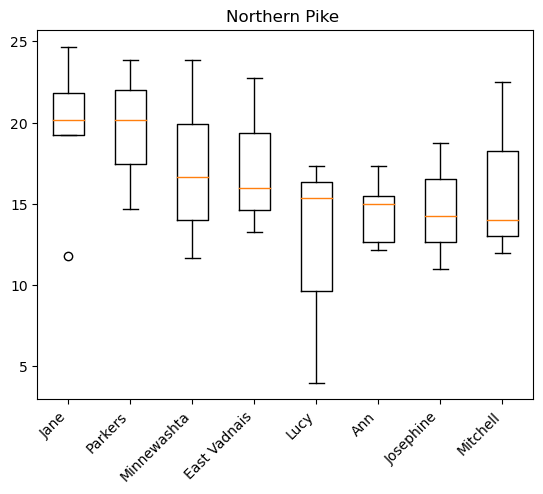

In [22]:
#plot boxplot of CPUE per lake
cpue_list_length = len(cpue_list)
plot_cpue_box(cpue_list, cpue_results[:cpue_list_length])

In [23]:
#create fish CPUE data series for scatter plot and regression line
fish_cpue = get_cpue_scatter(fish_catch_df, cpue_results, species, start_date)

In [24]:
#create date series for cpue scatter plots and regression lines
cpue_sdate = get_survey_date_scatter(fish_catch_df, cpue_results, species, start_date)
cpue_ndate = get_numeric_survey_date_regress(fish_catch_df, cpue_results, species, start_date)

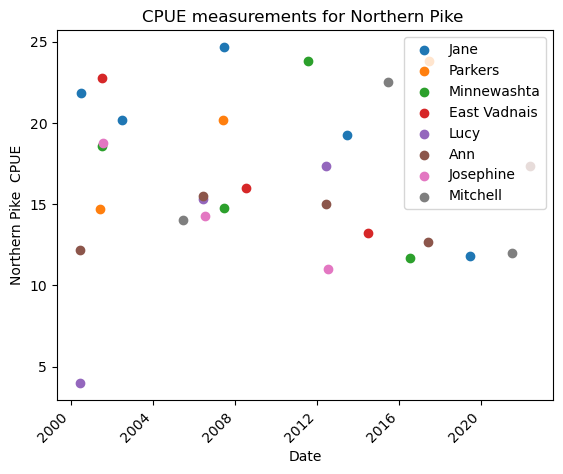

In [25]:
#plot scatter of CPUE per lake
plot_scatter(fish_cpue, cpue_sdate, cpue_results, ytext="CPUE")

Notes:


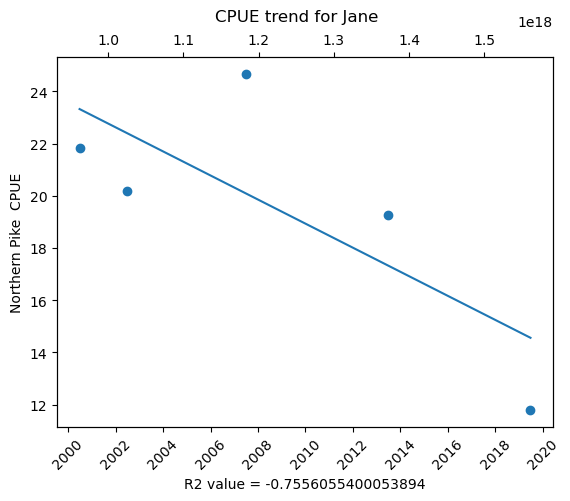

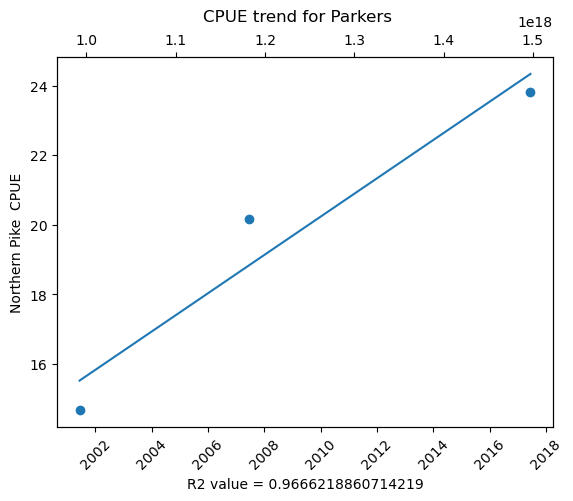

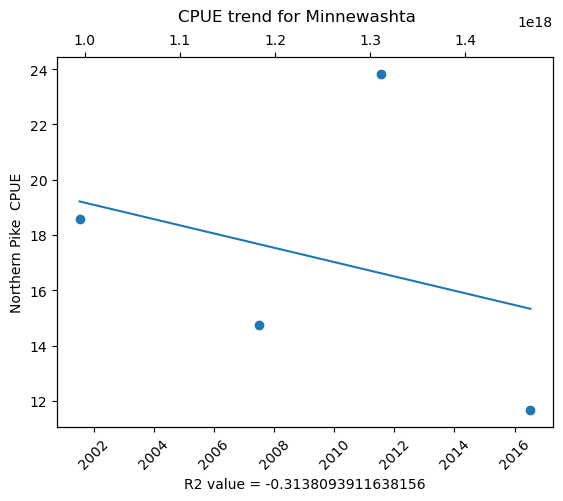

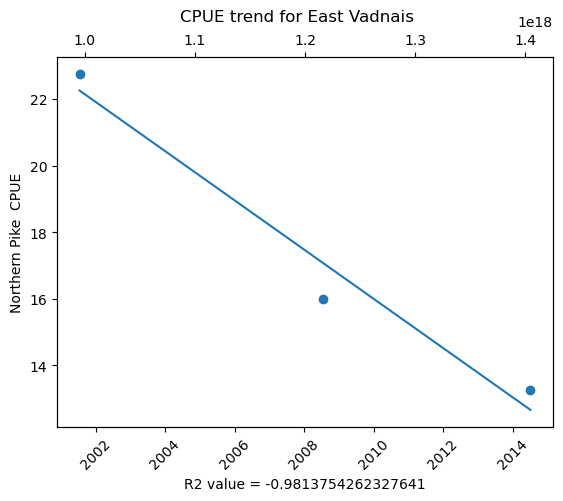

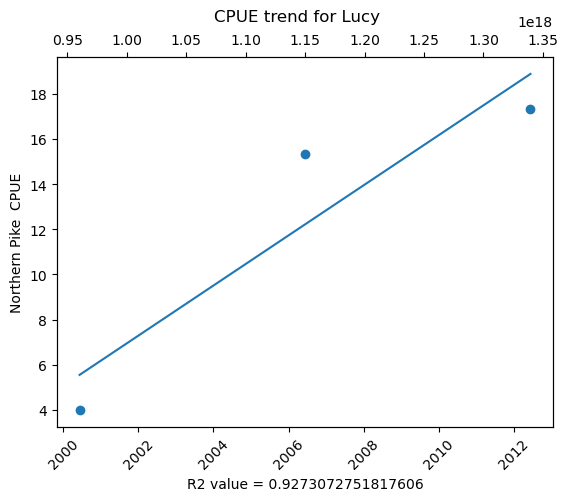

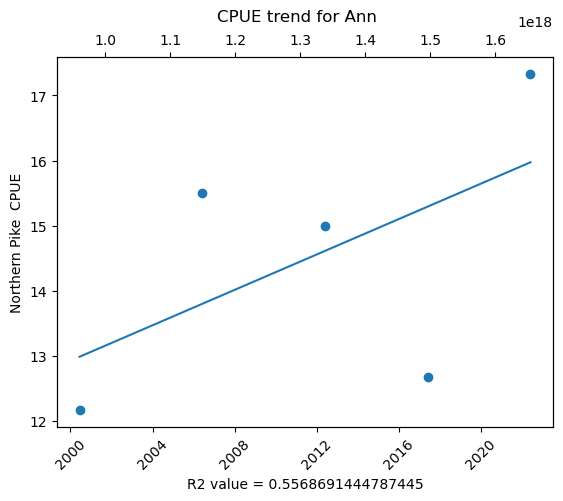

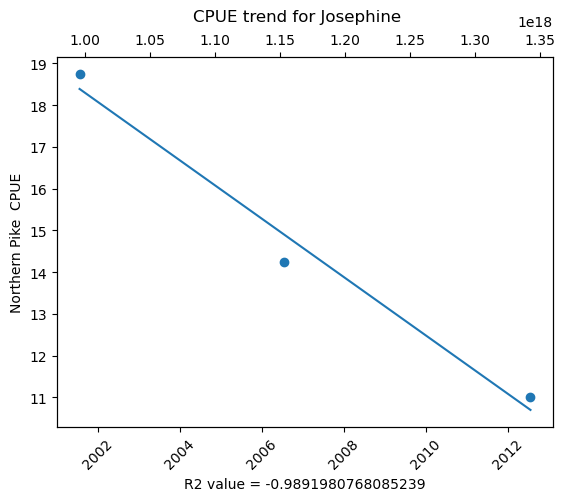

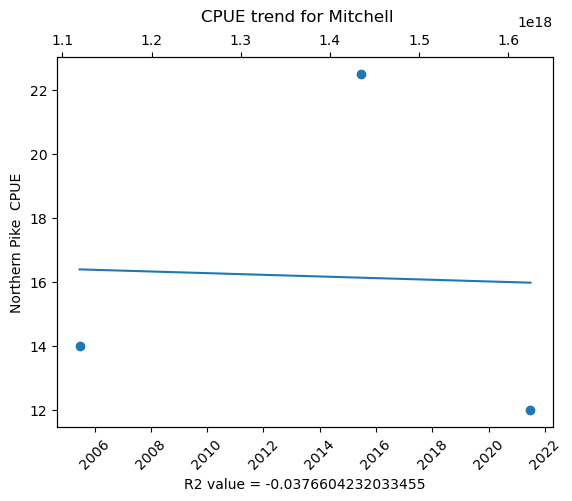

In [26]:
#plot regression lines for each lake CPUE over time
plot_regression_scatter(fish_cpue, cpue_sdate, cpue_ndate, cpue_results, "CPUE")

In [27]:
#create a datafram for lengths
fish_length_df = create_length_dataframe(fish_data)

In [28]:
#clean length data
fish_length_df["survey_date"] = survey_date_cleaner(fish_length_df["survey_date"])
fish_length_df["fish_count"] = fish_length_cleaner(fish_length_df["fish_count"])
#add an average length column
fish_length_df["average_length"] = fish_length_averager(fish_length_df["fish_count"])
fish_length_df = fish_length_df.sort_values("survey_date")

In [29]:
#add numeric survey date column as an integer to fish length
fish_length_df["survey_date"] = pd.to_datetime(fish_length_df["survey_date"],format="%Y-%m-%d")
fish_length_df["numeric_survey_date"] = pd.to_numeric(fish_length_df["survey_date"])
fish_length_df = fish_length_df.sort_values("survey_date")
fish_length_df = fish_length_df.reset_index(drop=True)

In [30]:
#create date series for length scatter plots and regression lines
length_sdate = get_survey_date_scatter(fish_length_df, cpue_results, species, start_date)
length_ndate = get_numeric_survey_date_regress(fish_length_df, cpue_results, species, start_date)

In [31]:
#filter and prepare a list of lengths for histogram plots
lengthdict = get_length_hist(fish_length_df, cpue_results, species, start_date)

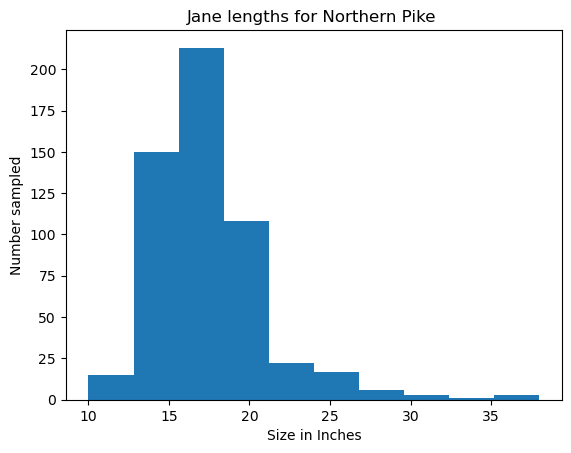

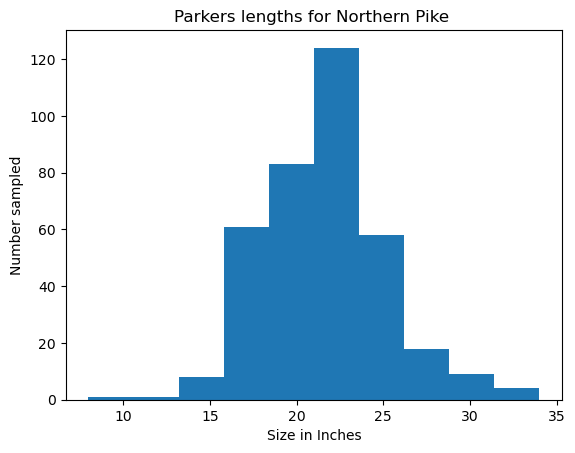

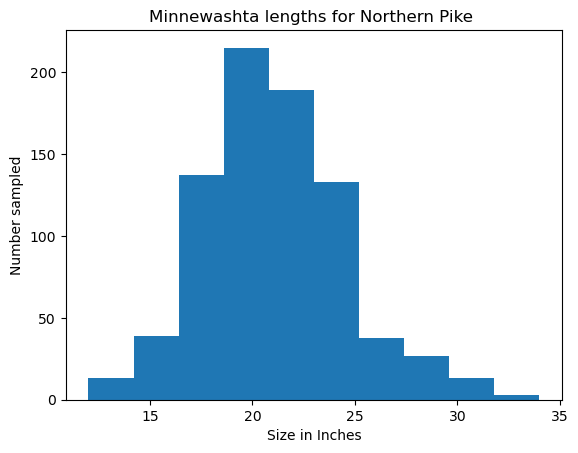

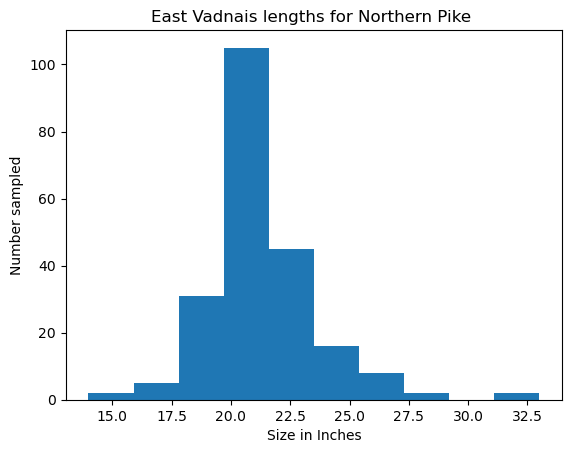

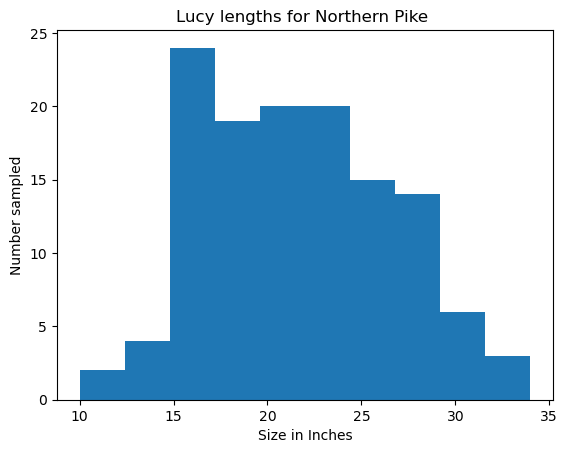

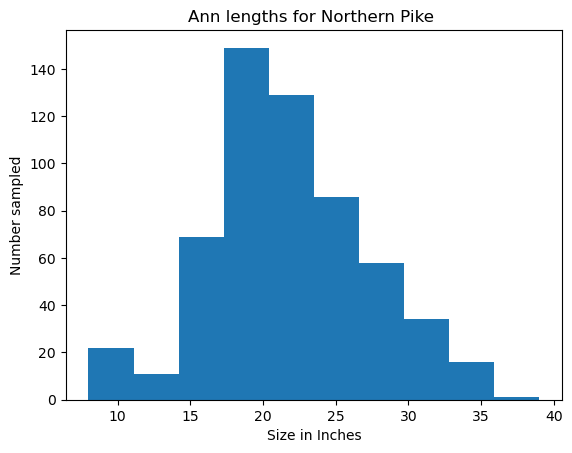

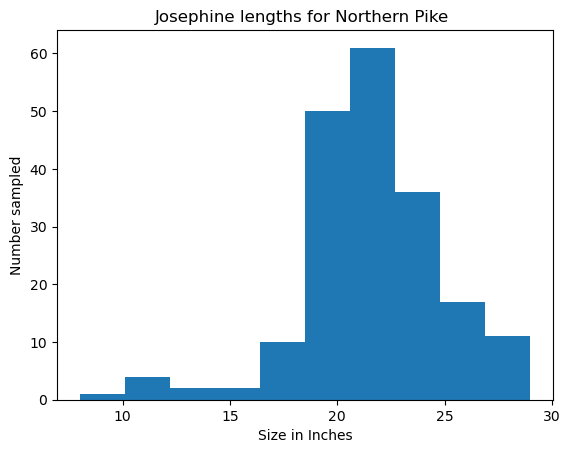

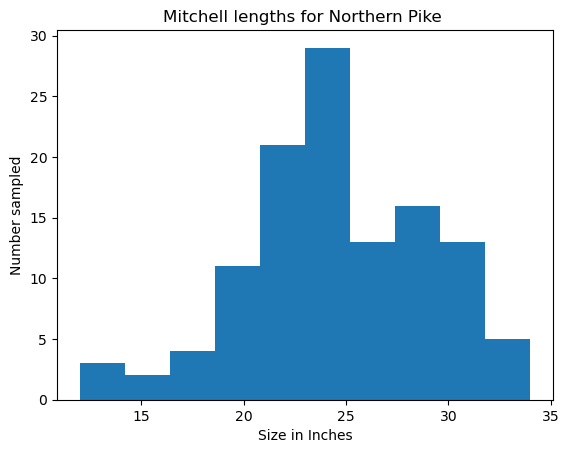

In [32]:
#plot histograms of lengths per lake
plot_length_hist(lengthdict)

In [33]:
#create an average fish length data series for scatter plot and regression line
fishavglength = get_avglen_scatter(fish_length_df, cpue_results, species, start_date)

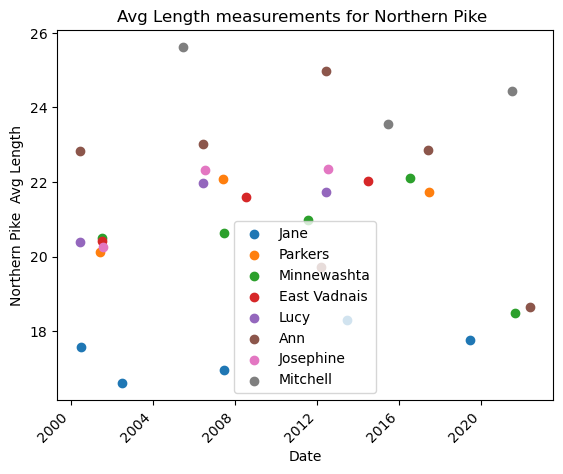

In [34]:
#plot scatter of average fish lengths per lake
plot_scatter(fishavglength, length_sdate, cpue_results, "Avg Length")

Notes:


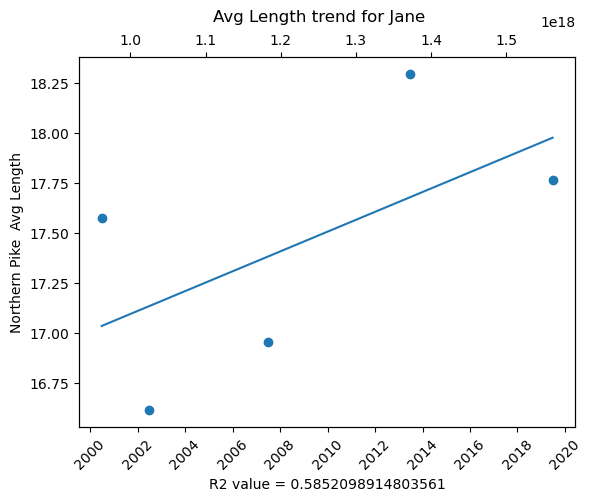

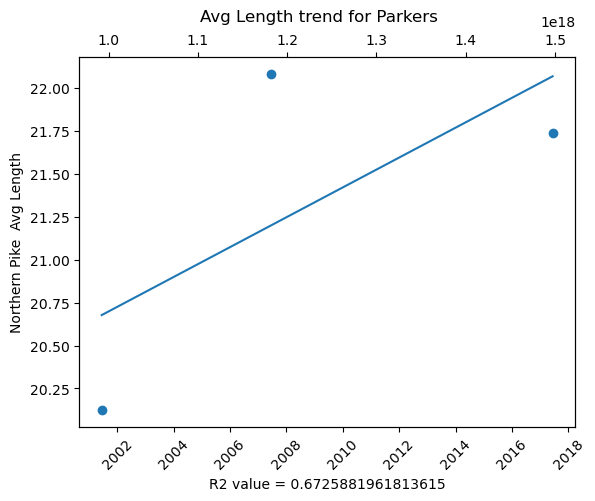

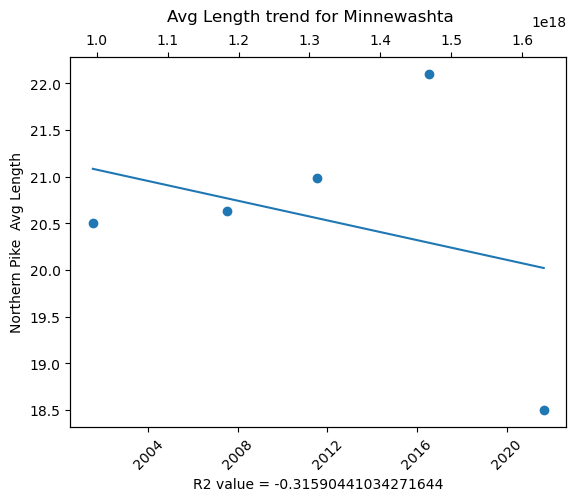

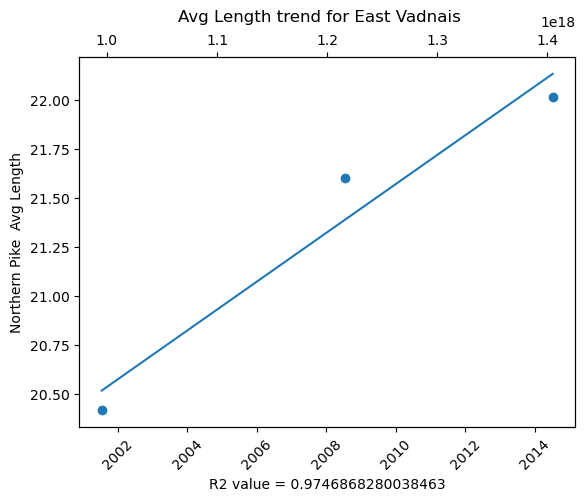

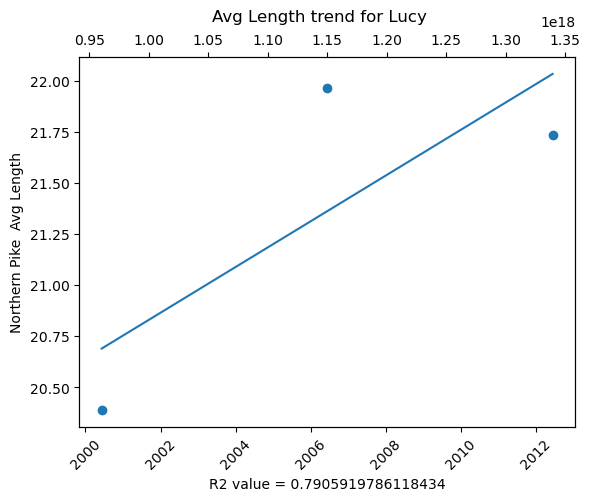

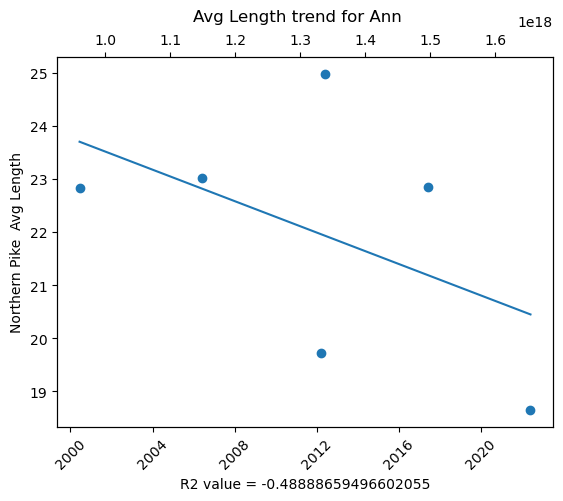

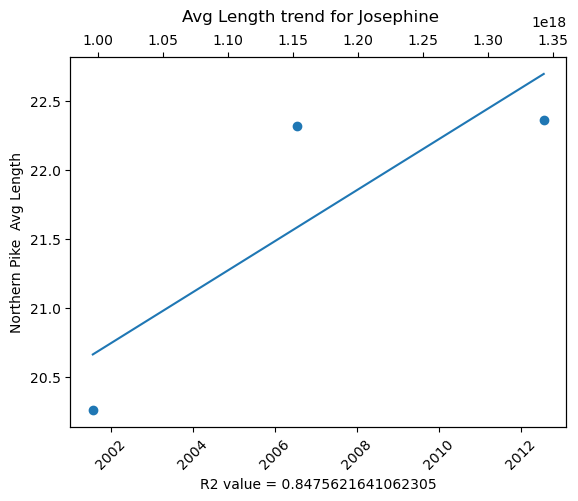

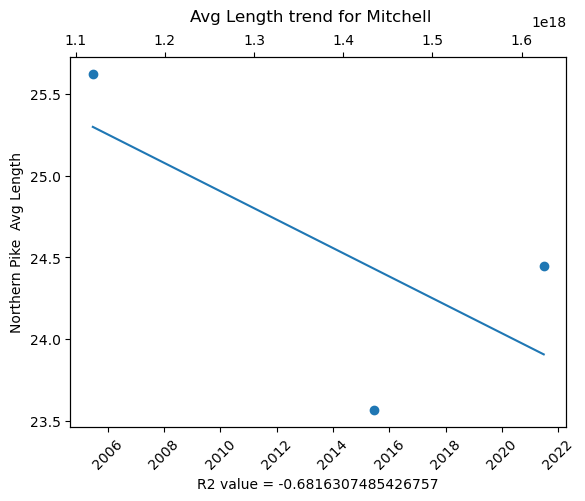

In [35]:
#plot regression lines for each lake average fish length over time
plot_regression_scatter(fishavglength, length_sdate, length_ndate, cpue_results, "Avg Length")

#### End of Report